# Part 2: Modelling

In this notebook, we will be splitting the data into train, test and validation sets, and use the following Machine Learning models to conduct the binary classification task.


1. Multinomial Naive Bayes with Count Vectorizer (Benchmark)
2. Logistic Regresssion
3. XGBoost Classifier
4. Random Forest Classifier

For models 2-4, we will run them with both CountVectorizer & TF-IDF Vectorizer and conduct hyperparameter tuning using `RandomizedSearchCV`.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import pickle
import warnings

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# random state for the entire notebook
seed=99

## Importing Datasets

In [2]:
df = pd.read_csv('../data/reviews_clean.csv')

In [3]:
display(df.head())
display(df.shape)

,category,rating,label,text,class,clean_text,text_word_length
0,home_and_kitchen,5.0,CG,"Love this! Well made, sturdy, and very comfor...",1,love this well made sturdy and very comfortabl...,12
1,home_and_kitchen,5.0,CG,"love it, a great upgrade from the original. I...",1,love it a great upgrade from the original i ha...,16
2,home_and_kitchen,5.0,CG,This pillow saved my back. I love the look and...,1,this pillow saved my back i love the look and ...,14
3,home_and_kitchen,1.0,CG,"Missing information on how to use it, but it i...",1,missing information on how to use it but it is...,17
4,home_and_kitchen,5.0,CG,Very nice set. Good quality. We have had the s...,1,very nice set good quality we have had the set...,18


(40391, 7)

In [4]:
# 1 null observation after reading in csv
print(df.isnull().sum())

df.dropna(inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)

category            0
rating              0
label               0
text                0
class               0
clean_text          1
text_word_length    0
dtype: int64


## Validation and Testing Split


We will adopt a split of 70% training & 30% testing. The 70% training set will be further split into training and validation sets (80-20 split).

The training and validation data will be refit before predicting the test set.

In [5]:
X = df['clean_text']
y = df['class']

In [6]:
# split training and remainder data (to be further split into testing and validation sets) for BoW models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# preparing the training + validation set to predict the test set
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

## Benchmark Model: BoW with Multinomial Naive Bayes

### Reusable Function to Display Metrics

In [7]:
def metrics(fitted_estimator, X_train=X_train, X_test=X_val, y_train=y_train, y_test=y_val, hyperparam_tuning=False, test_set=False):
    '''

    Takes input of a fitted estimator and outputs the various classification metrics. if the fitted model is a gridsearch
    It will also output the best params_ and best_score_.

    '''
    pred = fitted_estimator.predict(X_test)
    pred_proba = fitted_estimator.predict_proba(X_test)[:,1]
    recall = round(recall_score(y_test, pred),3)
    precision = round(precision_score(y_test, pred),3)
    f1 = round(f1_score(y_test, pred),3)
    training_score = round(fitted_estimator.score(X_train, y_train),5)
    validation_score = round(fitted_estimator.score(X_test, y_test),5)
    auc_score = round(roc_auc_score(y_test,pred_proba),3)


    display(ConfusionMatrixDisplay.from_predictions(y_test, pred))
    
    if hyperparam_tuning:
        display(f'Best Params:  {fitted_estimator.best_params_}')
        display(f'Best Score:   {round(fitted_estimator.best_score_,3)}')
        
    display(f'The training score is: {training_score}.')
    if test_set == False:
        display(f'The validation score is {validation_score}.')
        print()
    else: 
        display(f'The test score is {validation_score}.')
        print()
    display(f'The recall score is {recall}.')
    display(f'The precision score is {precision}.')
    display(f'The f1 score is {f1}.')
    display(f'The AUC score is {auc_score}.')
    
    return training_score, validation_score , recall, precision, f1, auc_score

### Validation Set Metrics

'The training score is: 0.85963.'

'The validation score is 0.83201.'

'The recall score is 0.903.'

'The precision score is 0.785.'

'The f1 score is 0.84.'

'The AUC score is 0.925.'

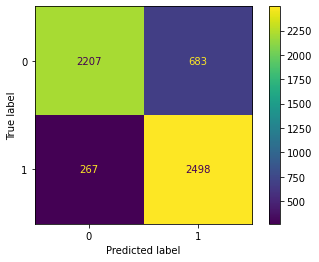

In [8]:
cvec = CountVectorizer(stop_words='english')

benchmark = Pipeline([
    ('cvec',cvec),
    ('mnb', MultinomialNB())
])

benchmark.fit(X_train, y_train)
benchmark_train, benchmark_validation, benchmark_recall, benchmark_precision, benchmark_f1, benchmark_auc = metrics(benchmark)

# creating a dictionary to consolidate all model scores to convert into a DataFrame later on
val_results = {'model':['Multinomial NB/CVEC (Benchmark)'],
           'training_score':[benchmark_train],
           'validation_score':[benchmark_validation],
           'validation_recall':[benchmark_recall],
           'validation_precision':[benchmark_precision],
           'validation_f1':[benchmark_f1],
           'validation_AUC_score':[benchmark_auc]}

#### Test Set Metrics

'The training score is: 0.85909.'

'The test score is 0.83049.'

'The recall score is 0.893.'

'The precision score is 0.796.'

'The f1 score is 0.842.'

'The AUC score is 0.923.'

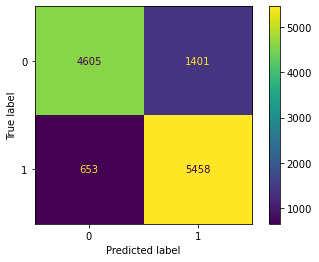

In [9]:
benchmark.fit(X_train_val, y_train_val)
benchmark_train, benchmark_test, benchmark_recall, benchmark_precision, benchmark_f1, benchmark_auc = metrics(benchmark,
                                                                                                              X_train = X_train_val,
                                                                                                              y_train = y_train_val,
                                                                                                              X_test = X_test,
                                                                                                              y_test = y_test,
                                                                                                              test_set=True)
                                                                                                                       

# creating a dictionary to consolidate all model scores to convert into a DataFrame later on
test_results = {'model':['Multinomial NB/CVEC (Benchmark)'],
               'training_score':[benchmark_train],
               'test_score':[benchmark_test],
               'test_recall':[benchmark_recall],
               'test_precision':[benchmark_precision],
               'test_f1':[benchmark_f1],
               'test_AUC_score':[benchmark_auc]}

filename = '../models/benchmark.sav'
pickle.dump(benchmark, open(filename, 'wb'))

## Candidate Models


As explained at the start of the notebook, each candidate model will be ran using the `CountVectorizer` and `TfidfVectorizer` for both validation and test sets.

### Logistic Regression
#### Count Vectorizer

"Best Params:  {'logreg__solver': 'newton-cg', 'logreg__C': 23.357214690901213, 'cvec__ngram_range': (1, 2)}"

'Best Score:   0.875'

'The training score is: 1.0.'

'The validation score is 0.88318.'

'The recall score is 0.883.'

'The precision score is 0.873.'

'The f1 score is 0.878.'

'The AUC score is 0.951.'

Wall time: 8min 28s


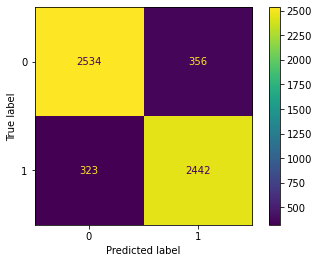

In [10]:
%%time

logr_c = Pipeline([
    ('cvec',cvec),
    ('logreg', LogisticRegression(random_state=seed))
])

logr_c_params = {
    'cvec__ngram_range':[(1,1), (1,2), (1,3)],
    'logreg__C': np.logspace(-2,2,20),
    'logreg__solver':['newton-cg', 'liblinear']
} 

rs1 = RandomizedSearchCV(logr_c,
                         logr_c_params,
                         n_iter=100,
                         cv=3,
                         scoring='recall',
                         random_state=seed,
                         n_jobs= -1)
                         
rs1.fit(X_train, y_train)
logr_c_train, logr_c_validation, logr_c_recall, logr_c_precision, logr_c_f1, logr_c_auc = metrics(rs1, hyperparam_tuning=True)

# Record scores

val_results['model'].append('Logistic Regression/CVEC')
val_results['training_score'].append(logr_c_train)
val_results['validation_score'].append(logr_c_validation)
val_results['validation_recall'].append(logr_c_recall)
val_results['validation_precision'].append(logr_c_precision)
val_results['validation_f1'].append(logr_c_f1)
val_results['validation_AUC_score'].append(logr_c_auc)

'The training score is: 1.0.'

'The test score is 0.88938.'

'The recall score is 0.889.'

'The precision score is 0.891.'

'The f1 score is 0.89.'

'The AUC score is 0.958.'

Wall time: 12min 17s


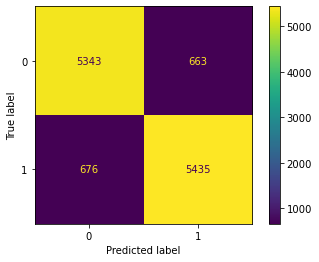

In [11]:
%%time
rs1.fit(X_train_val, y_train_val)
logr_c_train, logr_c_validation, logr_c_recall, logr_c_precision, logr_c_f1, logr_c_auc = metrics(rs1,
                                                                                            X_train = X_train_val,
                                                                                            y_train = y_train_val,
                                                                                            X_test = X_test,
                                                                                            y_test = y_test,
                                                                                            test_set=True)

# creating a dictionary to consolidate all model scores to convert into a DataFrame later on
test_results['model'].append('Logistic Regression/CVEC')
test_results['training_score'].append(logr_c_train)
test_results['test_score'].append(logr_c_validation)
test_results['test_recall'].append(logr_c_recall)
test_results['test_precision'].append(logr_c_precision)
test_results['test_f1'].append(logr_c_f1)
test_results['test_AUC_score'].append(logr_c_auc)

filename = '../models/logr_c.sav'
pickle.dump(rs1, open(filename, 'wb'))

#### TF-IDF Vectorizer

"Best Params:  {'tvec__ngram_range': (1, 3), 'logreg__solver': 'newton-cg', 'logreg__C': 100.0}"

'Best Score:   0.895'

'The training score is: 1.0.'

'The validation score is 0.90235.'

'The recall score is 0.902.'

'The precision score is 0.861.'

'The f1 score is 0.881.'

'The AUC score is 0.953.'

Wall time: 2min 51s


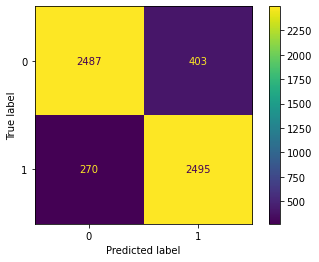

In [12]:
%%time
tvec = TfidfVectorizer(stop_words='english')

logr = Pipeline([
    ('tvec',tvec),
    ('logreg', LogisticRegression(random_state=seed))
])

logr_params = {
    'tvec__ngram_range':[(1,1), (1,2), (1,3)],
    'logreg__C': np.logspace(-2,2,20),
    'logreg__solver':['newton-cg', 'liblinear']
} 

rs2 = RandomizedSearchCV(logr,
                         logr_params,
                         n_iter=100,
                         cv=3,
                         scoring='recall',
                         random_state=seed,
                         n_jobs= -1)
                         
rs2.fit(X_train, y_train)
logr_train, logr_validation, logr_recall, logr_precision, logr_f1, logr_auc = metrics(rs2, hyperparam_tuning=True)

# Record scores
val_results['model'].append('Logistic Regression/TVEC')
val_results['training_score'].append(logr_train)
val_results['validation_score'].append(logr_validation)
val_results['validation_recall'].append(logr_recall)
val_results['validation_precision'].append(logr_precision)
val_results['validation_f1'].append(logr_f1)
val_results['validation_AUC_score'].append(logr_auc)

'The training score is: 1.0.'

'The test score is 0.90247.'

'The recall score is 0.902.'

'The precision score is 0.879.'

'The f1 score is 0.891.'

'The AUC score is 0.957.'

Wall time: 3min 42s


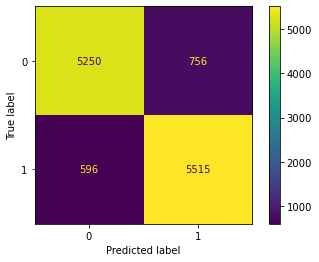

In [13]:
%%time
rs2.fit(X_train_val, y_train_val)
logr_train, logr_validation, logr_recall, logr_precision, logr_f1, logr_auc = metrics(rs2, 
                                                                                X_train = X_train_val,
                                                                                y_train = y_train_val,
                                                                                X_test = X_test,
                                                                                y_test = y_test,
                                                                                test_set=True)

# creating a dictionary to consolidate all model scores to convert into a DataFrame later on
test_results['model'].append('Logistic Regression/TVEC')
test_results['training_score'].append(logr_train)
test_results['test_score'].append(logr_validation)
test_results['test_recall'].append(logr_recall)
test_results['test_precision'].append(logr_precision)
test_results['test_f1'].append(logr_f1)
test_results['test_AUC_score'].append(logr_auc)

filename = '../models/logr.sav'
pickle.dump(rs2, open(filename, 'wb'))

### XGBoost Classifier
#### CountVectorizer

"Best Params:  {'xgb__subsample': 0.6, 'xgb__reg_lambda': 0.3593813663804626, 'xgb__reg_alpha': 0.016681005372000592, 'xgb__n_estimators': 150, 'xgb__max_depth': 15, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0.7000000000000001, 'xgb__colsample_bytree': 0.5, 'cvec__ngram_range': (1, 1)}"

'Best Score:   0.832'

'The training score is: 0.90672.'

'The validation score is 0.83906.'

'The recall score is 0.839.'

'The precision score is 0.846.'

'The f1 score is 0.843.'

'The AUC score is 0.934.'

Wall time: 11min 9s


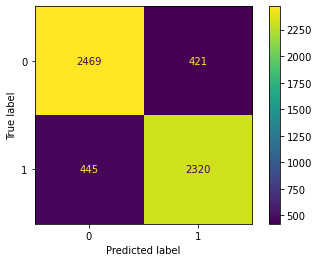

In [14]:
%%time

xgb_pipe = Pipeline([
    ('cvec',cvec),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=seed))
])

xgb_params = {
    'cvec__ngram_range':[(1,1), (1,2), (1,3)],
    'xgb__n_estimators': [50,100,120,150],
    'xgb__max_depth': [5,10,15],
    'xgb__colsample_bytree':[0.2,0.3,0.5],
    'xgb__subsample':np.linspace(0.1,0.8,8),
    'xgb__gamma':np.linspace(0.1,1,10),
    'xgb__learning_rate':np.linspace(0.01,0.2,10),
    'xgb__reg_alpha': np.logspace(-2,0,10),
    'xgb__reg_lambda':np.logspace(-2,0,10)
}

rs3 = RandomizedSearchCV(xgb_pipe,
                         xgb_params,
                         n_iter=100,
                         cv=3,
                         scoring='recall',
                         random_state=seed,
                         n_jobs = -1)
                         
rs3.fit(X_train, y_train)
xgb_c_train, xgb_c_validation, xgb_c_recall, xgb_c_precision, xgb_c_f1, xgb_c_auc = metrics(rs3, hyperparam_tuning=True)

# Record scores
val_results['model'].append('XGB/CVEC')
val_results['training_score'].append(xgb_c_train)
val_results['validation_score'].append(xgb_c_validation)
val_results['validation_recall'].append(xgb_c_recall)
val_results['validation_precision'].append(xgb_c_precision)
val_results['validation_f1'].append(xgb_c_f1)
val_results['validation_AUC_score'].append(xgb_c_auc)

"Best Params:  {'xgb__subsample': 0.6, 'xgb__reg_lambda': 0.016681005372000592, 'xgb__reg_alpha': 0.027825594022071243, 'xgb__n_estimators': 150, 'xgb__max_depth': 15, 'xgb__learning_rate': 0.1788888888888889, 'xgb__gamma': 0.4, 'xgb__colsample_bytree': 0.5, 'cvec__ngram_range': (1, 1)}"

'Best Score:   0.832'

'The training score is: 0.89733.'

'The test score is 0.82572.'

'The recall score is 0.826.'

'The precision score is 0.866.'

'The f1 score is 0.846.'

'The AUC score is 0.934.'

Wall time: 14min 4s


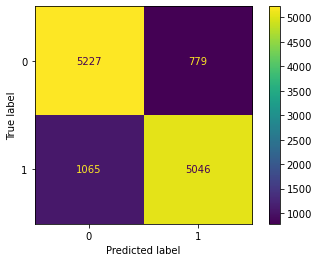

In [15]:
%%time
rs3.fit(X_train_val, y_train_val)
xgb_c_train, xgb_c_validation, xgb_c_recall, xgb_c_precision, xgb_c_f1, xgb_c_auc = metrics(rs3,
                                                                                            X_train = X_train_val,
                                                                                            y_train = y_train_val,
                                                                                            X_test = X_test,
                                                                                            y_test = y_test,
                                                                                            test_set=True,
                                                                                            hyperparam_tuning=True)

# Record scores
test_results['model'].append('XGB/CVEC')
test_results['training_score'].append(xgb_c_train)
test_results['test_score'].append(xgb_c_validation)
test_results['test_recall'].append(xgb_c_recall)
test_results['test_precision'].append(xgb_c_precision)
test_results['test_f1'].append(xgb_c_f1)
test_results['test_AUC_score'].append(xgb_c_auc)


filename = '../models/xgb_c.sav'
pickle.dump(rs3, open(filename, 'wb'))

#### TF-IDF Vectorizer

"Best Params:  {'xgb__subsample': 0.5, 'xgb__reg_lambda': 0.016681005372000592, 'xgb__reg_alpha': 0.0774263682681127, 'xgb__n_estimators': 120, 'xgb__max_depth': 15, 'xgb__learning_rate': 0.1366666666666667, 'xgb__gamma': 0.8, 'xgb__colsample_bytree': 0.5, 'tvec__ngram_range': (1, 3)}"

'Best Score:   0.916'

'The training score is: 0.90893.'

'The validation score is 0.91646.'

'The recall score is 0.916.'

'The precision score is 0.638.'

'The f1 score is 0.752.'

'The AUC score is 0.859.'

Wall time: 13min 57s


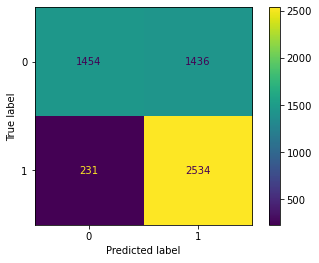

In [16]:
%%time
xgb_pipe = Pipeline([
    ('tvec',tvec),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=seed))
])

xgb_params = {
    'tvec__ngram_range':[(1,1), (1,2), (1,3)],
    'xgb__n_estimators': [50,100,120,150],
    'xgb__max_depth': [5,10,15],
    'xgb__colsample_bytree':[0.2,0.3,0.5],
    'xgb__subsample':np.linspace(0.1,0.8,8),
    'xgb__gamma':np.linspace(0.1,1,10),
    'xgb__learning_rate':np.linspace(0.01,0.2,10),
    'xgb__reg_alpha': np.logspace(-2,0,10),
    'xgb__reg_lambda':np.logspace(-2,0,10)
}

rs4 = RandomizedSearchCV(xgb_pipe,
                         xgb_params,
                         n_iter=100,
                         cv=3,
                         scoring='recall',
                         random_state=seed,
                         n_jobs = -1)
                         
rs4.fit(X_train, y_train)
xgb_train, xgb_validation, xgb_recall, xgb_precision, xgb_f1, xgb_auc = metrics(rs4, hyperparam_tuning=True)

# record scores
val_results['model'].append('XGB/TVEC')
val_results['training_score'].append(xgb_train)
val_results['validation_score'].append(xgb_validation)
val_results['validation_recall'].append(xgb_recall)
val_results['validation_precision'].append(xgb_precision)
val_results['validation_f1'].append(xgb_f1)
val_results['validation_AUC_score'].append(xgb_auc)

"Best Params:  {'xgb__subsample': 0.30000000000000004, 'xgb__reg_lambda': 0.01, 'xgb__reg_alpha': 0.3593813663804626, 'xgb__n_estimators': 120, 'xgb__max_depth': 15, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0.30000000000000004, 'xgb__colsample_bytree': 0.5, 'tvec__ngram_range': (1, 3)}"

'Best Score:   0.923'

'The training score is: 0.9038.'

'The test score is 0.92194.'

'The recall score is 0.922.'

'The precision score is 0.637.'

'The f1 score is 0.753.'

'The AUC score is 0.845.'

Wall time: 17min 53s


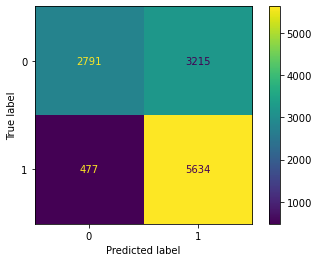

In [17]:
%%time
rs4.fit(X_train_val, y_train_val)
xgb_train, xgb_validation, xgb_recall, xgb_precision, xgb_f1, xgb_auc = metrics(rs4,
                                                                                X_train = X_train_val,
                                                                                y_train = y_train_val,
                                                                                X_test = X_test,
                                                                                y_test = y_test,
                                                                                test_set=True,
                                                                                hyperparam_tuning=True)

# Record scores
test_results['model'].append('XGB/TVEC')
test_results['training_score'].append(xgb_train)
test_results['test_score'].append(xgb_validation)
test_results['test_recall'].append(xgb_recall)
test_results['test_precision'].append(xgb_precision)
test_results['test_f1'].append(xgb_f1)
test_results['test_AUC_score'].append(xgb_auc)


filename = '../models/xgb.sav'
pickle.dump(rs4, open(filename, 'wb'))

### Random Forest Classifier
#### CountVectorizer

"Best Params:  {'rf__n_estimators': 200, 'rf__min_samples_split': 20, 'rf__min_samples_leaf': 5, 'rf__max_features': 'log2', 'rf__max_depth': 80, 'cvec__ngram_range': (1, 1)}"

'Best Score:   0.905'

'The training score is: 0.91867.'

'The validation score is 0.90778.'

'The recall score is 0.908.'

'The precision score is 0.69.'

'The f1 score is 0.784.'

'The AUC score is 0.874.'

Wall time: 2min 25s


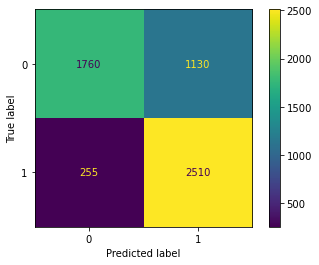

In [18]:
%%time
rf_c_pipe = Pipeline([
    ('cvec',cvec),
    ('rf', RandomForestClassifier(random_state=seed))
])

rf_c_params = {
    'cvec__ngram_range':[(1,1), (1,2), (1,3)],
    'rf__n_estimators':[50,100,150,200],
    'rf__max_depth':range(20,100,20),
    'rf__max_features':['auto', 'sqrt','log2'],
    'rf__min_samples_split':[5,10,20],
    'rf__min_samples_leaf':[5,10,20]   
}

rs5 = RandomizedSearchCV(rf_c_pipe,
                         rf_c_params,
                         n_iter=100,
                         cv=3,
                         scoring='recall',
                         random_state=seed,
                         n_jobs = -1)
                         
rs5.fit(X_train, y_train)
rf_c_train, rf_c_validation, rf_c_recall, rf_c_precision, rf_c_f1, rf_c_auc = metrics(rs5, hyperparam_tuning=True)

# record scores
val_results['model'].append('RF/CVEC')
val_results['training_score'].append(rf_c_train)
val_results['validation_score'].append(rf_c_validation)
val_results['validation_recall'].append(rf_c_recall)
val_results['validation_precision'].append(rf_c_precision)
val_results['validation_f1'].append(rf_c_f1)
val_results['validation_AUC_score'].append(rf_c_auc)

"Best Params:  {'rf__n_estimators': 200, 'rf__min_samples_split': 20, 'rf__min_samples_leaf': 5, 'rf__max_features': 'log2', 'rf__max_depth': 80, 'cvec__ngram_range': (1, 1)}"

'Best Score:   0.864'

'The training score is: 0.88524.'

'The test score is 0.86974.'

'The recall score is 0.87.'

'The precision score is 0.749.'

'The f1 score is 0.805.'

'The AUC score is 0.885.'

Wall time: 3min 5s


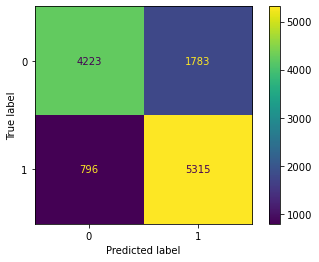

In [19]:
%%time
rs5.fit(X_train_val, y_train_val)
rf_c_train, rf_c_validation, rf_c_recall, rf_c_precision, rf_c_f1, rf_c_auc = metrics(rs5,
                                                                                      X_train = X_train_val,
                                                                                      y_train = y_train_val,
                                                                                      X_test = X_test,
                                                                                      y_test = y_test,
                                                                                      test_set=True,
                                                                                      hyperparam_tuning=True)

# record scores
test_results['model'].append('RF/CVEC')
test_results['training_score'].append(rf_c_train)
test_results['test_score'].append(rf_c_validation)
test_results['test_recall'].append(rf_c_recall)
test_results['test_precision'].append(rf_c_precision)
test_results['test_f1'].append(rf_c_f1)
test_results['test_AUC_score'].append(rf_c_auc)


filename = '../models/rf_c.sav'
pickle.dump(rs5, open(filename, 'wb'))

#### TF-IDF Vectorizer

"Best Params:  {'tvec__ngram_range': (1, 1), 'rf__n_estimators': 150, 'rf__min_samples_split': 20, 'rf__min_samples_leaf': 5, 'rf__max_features': 'log2', 'rf__max_depth': 80}"

'Best Score:   0.87'

'The training score is: 0.89096.'

'The validation score is 0.88535.'

'The recall score is 0.885.'

'The precision score is 0.692.'

'The f1 score is 0.777.'

'The AUC score is 0.859.'

Wall time: 2min 45s


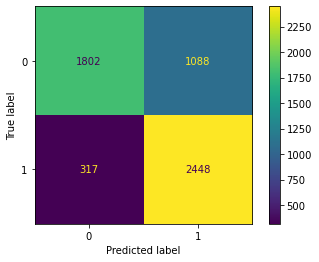

In [20]:
%%time

rf_pipe = Pipeline([
    ('tvec',tvec),
    ('rf', RandomForestClassifier(random_state=seed))
])

rf_params = {
    'tvec__ngram_range':[(1,1), (1,2), (1,3)],
    'rf__n_estimators':[50,100,150,200],
    'rf__max_depth':range(20,100,20),
    'rf__max_features':['auto', 'sqrt','log2'],
    'rf__min_samples_split':[5,10,20],
    'rf__min_samples_leaf':[5,10,20]   
}

rs6 = RandomizedSearchCV(rf_pipe,
                         rf_params,
                         n_iter=100,
                         cv=3,
                         scoring='recall',
                         random_state=seed,
                         n_jobs = -1)
                         
rs6.fit(X_train, y_train)
rf_train, rf_validation, rf_recall, rf_precision, rf_f1, rf_auc = metrics(rs6, hyperparam_tuning=True)

# record scores
val_results['model'].append('RF/TVEC')
val_results['training_score'].append(rf_train)
val_results['validation_score'].append(rf_validation)
val_results['validation_recall'].append(rf_recall)
val_results['validation_precision'].append(rf_precision)
val_results['validation_f1'].append(rf_f1)
val_results['validation_AUC_score'].append(rf_auc)

"Best Params:  {'tvec__ngram_range': (1, 2), 'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 5, 'rf__max_features': 'sqrt', 'rf__max_depth': 80}"

'Best Score:   0.833'

'The training score is: 0.81278.'

'The test score is 0.83178.'

'The recall score is 0.832.'

'The precision score is 0.808.'

'The f1 score is 0.82.'

'The AUC score is 0.905.'

Wall time: 3min 43s


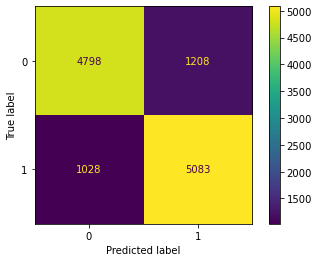

In [21]:
%%time
rs6.fit(X_train_val, y_train_val)
rf_train, rf_validation, rf_recall, rf_precision, rf_f1, rf_auc = metrics(rs6,
                                                                          X_train = X_train_val,
                                                                          y_train = y_train_val,
                                                                          X_test = X_test,
                                                                          y_test = y_test,
                                                                          test_set=True,
                                                                          hyperparam_tuning=True)

# record scores
test_results['model'].append('RF/TVEC')
test_results['training_score'].append(rf_train)
test_results['test_score'].append(rf_validation)
test_results['test_recall'].append(rf_recall)
test_results['test_precision'].append(rf_precision)
test_results['test_f1'].append(rf_f1)
test_results['test_AUC_score'].append(rf_auc)

filename = '../models/rf.sav'
pickle.dump(rs6, open(filename, 'wb'))

### Validation Scores

In [22]:
df_results = pd.DataFrame(val_results)
df_results

,model,training_score,validation_score,validation_recall,validation_precision,validation_f1,validation_AUC_score
0,Multinomial NB/CVEC (Benchmark),0.85963,0.83201,0.903,0.785,0.840,0.925
1,Logistic Regression/CVEC,1.00000,0.88318,0.883,0.873,0.878,0.951
2,Logistic Regression/TVEC,1.00000,0.90235,0.902,0.861,0.881,0.953
3,XGB/CVEC,0.90672,0.83906,0.839,0.846,0.843,0.934
4,XGB/TVEC,0.90893,0.91646,0.916,0.638,0.752,0.859
5,RF/CVEC,0.91867,0.90778,0.908,0.690,0.784,0.874
6,RF/TVEC,0.89096,0.88535,0.885,0.692,0.777,0.859


### Test Scores


From the results on the test set, we can observe that the **Logistic Regression/TF-IDF Vectorizer** is the best performing model.


On a whole, the tree-based models (XGB and Random Forest) did not perform as well as the Logistic Regression models for the evaluation metric (F1 score) and 3/4 tree-based models did not outperform the benchmark.

In [23]:
df_test = pd.DataFrame(test_results)
df_test

,model,training_score,test_score,test_recall,test_precision,test_f1,test_AUC_score
0,Multinomial NB/CVEC (Benchmark),0.85909,0.83049,0.893,0.796,0.842,0.923
1,Logistic Regression/CVEC,1.00000,0.88938,0.889,0.891,0.890,0.958
2,Logistic Regression/TVEC,1.00000,0.90247,0.902,0.879,0.891,0.957
3,XGB/CVEC,0.89733,0.82572,0.826,0.866,0.846,0.934
4,XGB/TVEC,0.90380,0.92194,0.922,0.637,0.753,0.845
5,RF/CVEC,0.88524,0.86974,0.870,0.749,0.805,0.885
6,RF/TVEC,0.81278,0.83178,0.832,0.808,0.820,0.905


In [24]:
df_test.to_csv('../data/df_test.csv', index=False)

### Examining Results of Best Performing Model

In [25]:
vectorizer = rs2.best_estimator_.named_steps['tvec']
classifier = rs2.best_estimator_.named_steps['logreg']

In [26]:
rs2.best_params_

{'tvec__ngram_range': (1, 3),
 'logreg__solver': 'newton-cg',
 'logreg__C': 100.0}

The vocabulary size of the model is about 1.04 million words (including unigrams, bigrams and trigrams)

In [27]:
# vocabulary size of the model
classifier.n_features_in_

1048017

We will extract the feature coefficients out for further examination.

In [28]:
# get feature names and coefficients from the logreg model
features = vectorizer.get_feature_names_out()
coefs = classifier.coef_.flatten()

In [41]:
# storing the info in a dataframe in preparation for visualization
zipped = zip(features, coefs)
df_feature = pd.DataFrame(zipped, columns=["feature", "value"])
df_feature['abs_value'] = df_feature['value'].apply(abs)
df_feature = df_feature.sort_values("abs_value", ascending=False)
df_feature["colors"] = df_feature["value"].apply(lambda x: "green" if x > 0 else "red")

From the figures below, the following can be observed:


* The word '**movie**' has a relatively high positive coefficient weight, this may result in a large number reviews (real or fake) in the `movies_and_TV` category to be classified as fake.

* The word '**woman**' has a relatively high positive coefficient weight, this may result in reviews of products that are primarily purchased by women (eg. `clothing_shoes_and_jewellery`) to be prone to being misclassified as fake.

* The word '**characters**' has a relatively high positive coefficient weight, this may result in reviews of products such as `movies & TV`, `books` and `kindle_store` to be more prone to being misclassified as fake.

Text(0.5, 0, 'Feature Name')

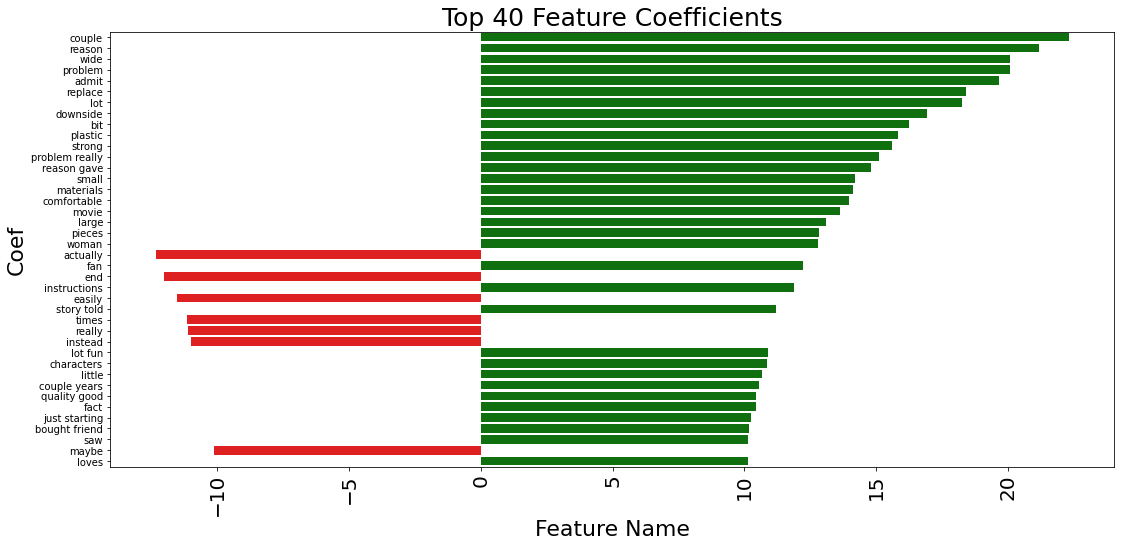

In [49]:
plt.figure(figsize=(18,8))
sns.barplot(y="feature",
            x="value",
            data=df_feature.head(40),
           palette=df_feature.head(40)["colors"], orient='horizontal')
plt.xticks(rotation=90, fontsize=20)
plt.title("Top 40 Feature Coefficients", fontsize=25)
plt.ylabel("Coef", fontsize=22)
plt.xlabel("Feature Name", fontsize=22)

The category distribution of test set is fairly balanced.

In [32]:
df_pred = df.iloc[X_test.index]
df_pred['category'].value_counts(normalize=True)

kindle_store                  0.117686
books                         0.110341
pet_supplies                  0.109268
home_and_kitchen              0.098044
electronics                   0.097962
clothing_shoes_and_jewelry    0.096559
sports_and_outdoors           0.096228
tools_and_home_improvement    0.093505
toys_and_games                0.092845
movies_and_tv                 0.087563
Name: category, dtype: float64

In the figures below, we drill down further to the category and class distribution of the misclassified reviews. We observe the following:


* The class distribution is slightly skewed to class 1 (reviews predicted as fake)

* `clothing_shoes_and_jewellery` and `pet supplies` have the largest number of misclassification. `home_and_kitchen` have the lowest misclassified reviews.

* Apart from `electronics`, misclassifications for the rest of the product categories are misclassification of a review as fake.

* As expected, misclassifications in the `movies & TV`, `books` , `kindle_store` and `clothing_shoes_and_jewellery` have the highest misclassification of reviews as fake due to the high coefficient of their related keywords (see above)

In [33]:
warnings.filterwarnings("ignore")

# create columns for the predictions and whether they differ from ground truth
df_pred['class_pred'] = rs2.predict(X_test)
df_pred['misclassification'] = (df_pred['class'] != df_pred['class_pred'])

# see misclassified reviews
wrong_preds = df_pred[(df_pred['misclassification'] ==True)]

wrong_preds['class_pred'].value_counts(normalize=True)

1    0.559172
0    0.440828
Name: class_pred, dtype: float64

Text(0.5, 1.0, 'Number of Misclassified Reviews by Category')

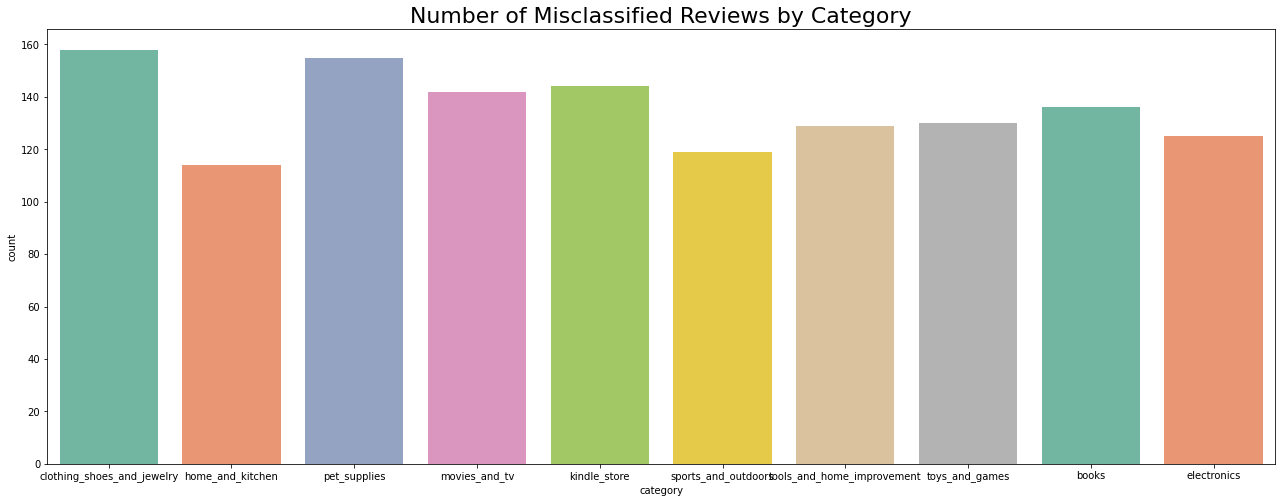

In [34]:
plt.figure(figsize=(22,8))
sns.countplot(x='category', data= wrong_preds, orient='horizontal', palette='Set2') 
plt.title('Number of Misclassified Reviews by Category', fontsize=22)

Text(0.5, 1.0, 'Number of Misclassified Reviews by Category/Class')

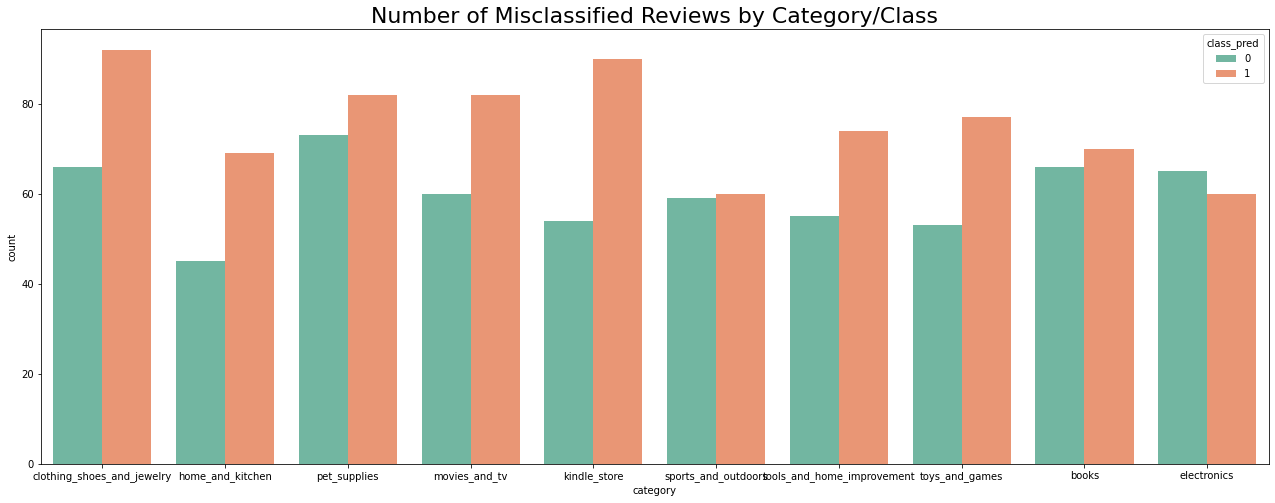

In [35]:
plt.figure(figsize=(22,8))
sns.countplot(x='category', data= wrong_preds, hue='class_pred', orient='horizontal', palette='Set2') 
plt.title('Number of Misclassified Reviews by Category/Class', fontsize=22)

# Notebook Conclusion

In this notebook, we have:
* Split the data into train, validation and test sets

* Implemented Machine Learning Models with Count Vectorization and TF-IDF Vectorization 

* Chose the **Logistic Regression with TF-IDF Vectorization** as the best performing Machine Learning model and examined its output.

In the next notebook, we will be building a classifier using Deep Learning.